**Objective:**  create a callable that receives $x^2$ and outputs $F(x^2)^2$.

Should be low level, and it should be possible easily save and read it.

**Database Docs**: ...

##### Handling the internal imports and getting data:

In [13]:
import sys
sys.path.insert(0, r"C:\Users\araujoj\Dropbox\montecarlo\tools")
from data import get_bookmarked_text, getAxis
from performance import timer

EPDL_path = r"C:\Users\araujoj\Dropbox\montecarlo\materials\EPDL"

def getData(Z):
    bookmarked_text = get_bookmarked_text(EPDL_path + f"\{Z}.txt")
    F = bookmarked_text[(7, 93, 0, 0, 0, 941)]

    Iflag, F = F
    xAxis, yAxis = getAxis(F)
    return xAxis, yAxis

##### Handling the external imports:

In [14]:
from matplotlib.pyplot import *
from numpy import *
%matplotlib inline

from numba import *

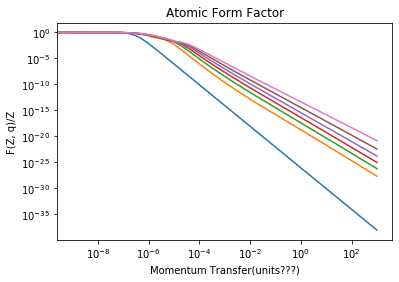

In [120]:
fig = figure()
ax = gca() #get current axis
ax.set_yscale('log')
ax.set_xscale('log')


ax.set_title("Atomic Form Factor")
ax.set_ylabel("F(Z, q)/Z")
ax.set_xlabel("Momentum Transfer(units???)")

for Z in range(1, 100, 15):
    xAxis, yAxis = getData(Z)
    ax.plot(xAxis , yAxis/Z)

#ax.set_xlim(min(xAxis), max(xAxis))
#ax.set_ylim(min(yAxis), max(yAxis))

This is the general look of the data.

The xAxis grid seems to be different for all elements:

In [121]:
xAxis, _ = getData(6)
print(len(xAxis))

xAxis, _ = getData(4)
print(len(xAxis))

1265
1290


This is probably because the data set was constructed to be interpolated. So, some regions will need higher density of points(where there is more curvature).

In penelope, they claim to use this function to fit the data set. [Link to paper](https://t.ly/5kIN).

[Hubbels data set](https://drive.google.com/file/d/1hbhDTCn1NGYZIB31K-OW21RsbFEPO9ta/view)

In [122]:
@timer
@njit
def func(x, a1, a2, a3, a4, a5):
    """x = 10**-10 * sin(theta/2)/lambda"""
    A = 1 + a1*x**2 + a2 * x**3 + a3 * x**4
    B = 1 + a4*x**2 + a5 * x**4
    return A/B**2

But I am yet to be able to perform a propper fit. Note that if I use scipy.optimize directly on that func, it just won't work.

I managed to line up the fit from Savat with the data from EPDL by multplying the xAxis by a factor of $10^6$. I don't know where it comes from.

func 0.0


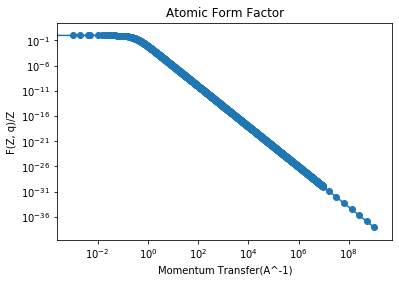

In [128]:
xAxis, yAxis = getData(1)    #data from EPDL
xAxis = xAxis*10**6          #mysterious 1e6 factor (on an adimensional quantity)
param = (0, 0, 0, 11.055, 0) #parameters taken directly form savat

fig = figure()
ax = gca() #get current axis
ax.set_yscale('log')
ax.set_xscale('log')


ax.set_title("Atomic Form Factor")
ax.set_ylabel("F(Z, q)/Z")
ax.set_xlabel("Momentum Transfer(A^-1)")
ax.plot(xAxis,  func(xAxis, *param))
ax.scatter(xAxis, yAxis)

The notebook was getting very disorganized, so I decided to start writing some classes to keep everything tidy.

In [17]:
#low level callables to use in the class

import scipy.optimize as opt
@njit
def func(x, a1, a2, a3, a4, a5):
    """x = 10**-10 * sin(theta/2)/lambda"""
    A = 1 + a1*x**2 + a2 * x**3 + a3 * x**4
    B = 1 + a4*x**2 + a5 * x**4
    return A/B**2


def logify(func):
    def new_func(*param, **kwargs):
        new_param = [exp(a) for a in param]
        return log(func(*new_param, **kwargs))
    return new_func

#@logify
@njit
def error(a1, a2, a3, a4, a5, w = w, xAxis = xAxis, yAxis = yAxis):
    #a1, a2, a3, a4, a5 = param
    #yAxisTrue = func(xAxis, *param)
    x = xAxis
    A = 1 + a1*x**2 + a2 * x**3 + a3 * x**4
    B = 1 + a4*x**2 + a5 * x**4
    yAxisTrue = A/B**2
    return sum(w*(yAxisTrue - yAxis)**2)


#spec = [('Z', int32), (), ()]
#@jitclass(spec)





class FormFactorWriter:
    ranges = (slice(0.01, 4, 10), 
              slice(0.01, 1, 10), 
              slice(0.01, 3, 50),  
              slice(0.01, 7, 10),  
              slice(0.01, 5, 10))
    def __init__(self, Z):
        self.bounds = [(log(s.start), log(s.stop)) for s in FormFactorWriter.ranges]
        self.Z = Z
        self.xAxis, self.yAxis = getData(Z)
        self.xAxis = self.xAxis*10**6
        
        
        self.w = self.yAxis**2 * (Z - self.yAxis)
        self.w = 1/self.w
        
        
        self.xAxis = self.xAxis[self.w != inf]
        self.yAxis = self.yAxis[self.w != inf]
        self.w = self.w[self.w != inf]
        
        #self.error = self.makeLowLevelError()
        #self.res = self.optimize()
        #self.param = self.res.x

        
    def fit(self, x):
        return func(x, *self.param)
    
    def error(self, param):
        return error(*param, w = self.w, xAxis = self.xAxis, yAxis = self.yAxis)
    
    def basinhopping(self):
        
        res = basinhopping(self.error, 
                           tuple(5*[0.5]),
                           niter = 200,
                           stepsize = 1e-3,
                           minimizer_kwargs = dict(method = 'Nelder-Mead'))
        
        self.res = res
        self.param = exp(self.res.x)
        self.param = exp(self.res.x)
        
    def brute(self, Ns = 10):
        res = brute(self.error, self.bounds, Ns=Ns)
        self.param = exp(res)
        self.err = self.error(self.param)
        print(self.err)
        
    def shgo(self):
        #self.bounds = [(None, None), ]*5
        
        g = lambda param: self.error(param) #>= 0
        cons = ({'type': 'eq', 'fun': g})
        
        res = shgo(self.error, 
                   self.bounds, 
                   constraints=None, 
                   n=60, 
                   sampling_method='sobol',
                   iters=30)
                   #n=800, 
                   #iters=1, 
                   #sampling_method='sobol',
                   #)
        self.res = res
        self.param = exp(self.res.x)
        
        #self.local_min = res.funl
    
    def plot(self):
        fig = figure()
        ax = gca() #get current axis
        ax.set_yscale('log')
        ax.set_xscale('log')


        ax.set_title("Atomic Form Factor")
        ax.set_ylabel("F(Z, q)/Z")
        ax.set_xlabel("Momentum Transfer(A^-1)")
        ax.plot(self.xAxis,  func(self.xAxis, *self.param))
        ax.scatter(self.xAxis, self.yAxis)
        

NameError: name 'w' is not defined

In [585]:
H = FormFactorWriter(2)

C:\Users\araujoj\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide


In [586]:
H.brute(Ns = 40)

KeyboardInterrupt: 

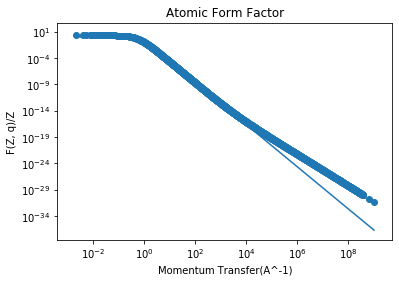

In [580]:
H.plot()

In [568]:
H.res

array([-2.32695236e+02, -2.72237884e+01, -7.01039244e-01,  2.06442017e-01,
        4.27357729e-01])

Alright, this is going nowhere. I'm going to probe the error function.

C:\Users\araujoj\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide


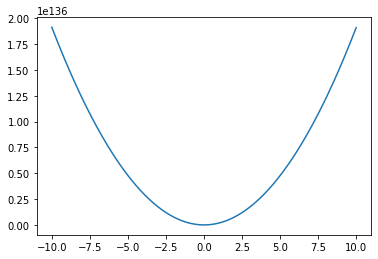

In [606]:
He = FormFactorWriter(2)
f1 = lambda x: He.error((x, 0, 0, 0, 0))
f2 = lambda x: He.error((0, x, 0, 0, 0))
f3 = lambda x: He.error((0, 0, x, 0, 0))
f4 = lambda x: He.error((0, 0, 0, x, 0))
f5 = lambda x: He.error((0, 0, 0, 2, x))


X = arange(-10, 10, .01)
Y = [f3(x) for x in X]
plot(X, Y)

# DIFFERENT APPROACH

First I'm going to try to follow this thing

https://math.stackexchange.com/questions/924482/least-squares-regression-matrix-for-rational-functions

and set up a linear equation to solve using

https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html


In [324]:
import sympy as sy
x, y, a1, a2, a3, a4, a5 = sy.symbols('x y a_1 a_2 a_3 a_4 a_5')

N = 1 + a1*x**2 + a2*x**3 + a3*x**4
D = 1 + a4*x**2 + a5* x**4
D = D**2
D.expand()

a_4**2*x**4 + 2*a_4*a_5*x**6 + 2*a_4*x**2 + a_5**2*x**8 + 2*a_5*x**4 + 1

So, if I wanna define a linear problem here, I'm gonna have to define some constraints here. Don't matter.

In [325]:
b1, b2, b3, b4 = sy.symbols('b_1 b_2 b_3 b_4')
D = 1 +b1*x**2 + b2*x**4 + b3*x**6 + b4*x**8
D

b_1*x**2 + b_2*x**4 + b_3*x**6 + b_4*x**8 + 1

In [484]:
coefs = [a1, a2, a3, b1, b2, b3, b4]
R = (N - D*y)
R = R.expand()
R

a_1*x**2 + a_2*x**3 + a_3*x**4 - b_1*x**2*y - b_2*x**4*y - b_3*x**6*y - b_4*x**8*y - y + 1

In [485]:
r = sy.collect(R, coefs, evaluate = False)
r[1] = -1*r[1]
r

{a_1: x**2,
 a_2: x**3,
 a_3: x**4,
 b_1: -x**2*y,
 b_2: -x**4*y,
 b_3: -x**6*y,
 b_4: -x**8*y,
 1: y - 1}

In [18]:
from numba import njit
from numpy import *

@njit
def error(a1, a2, a3, a4, a5, w = 1, xAxis = [], yAxis = []):
    #a1, a2, a3, a4, a5 = param
    #yAxisTrue = func(xAxis, *param)
    x = xAxis
    A = 1 + a1*x**2 + a2 * x**3 + a3 * x**4
    B = 1 + a4*x**2 + a5 * x**4
    yAxisTrue = A/B**2
    return sum(w*(yAxisTrue - yAxis)**2)


import sympy as sy
from sympy import Symbol
y = Symbol('y')
x = Symbol('x')

class FormFactorWriter:
    ranges = (slice(0, 10, 10), 
              slice(0, 10, 10), 
              slice(0, 10, 50),  
              slice(0, 15, 10),  
              slice(0, 10, 10))
    def __init__(self, Z, w):
        self.bounds = [(s.start, s.stop) for s in FormFactorWriter.ranges]
        print(self.bounds)
        w = sy.lambdify([x, y], w)
        
        #################################################################
        #GETTING DATA
        self.Z = Z
        self.xAxis, self.yAxis = getData(Z)
        self.xAxis = self.xAxis*10**6
        
        self.xAxis = self.xAxis[1e-5 < self.yAxis]
        self.yAxis = self.yAxis[1e-5 < self.yAxis]
        
        self.xAxis = self.xAxis[self.yAxis < 0.99*Z]
        self.yAxis = self.yAxis[self.yAxis < 0.99*Z]
        
        assert len(self.xAxis) == len(self.yAxis)
        
        self.yAxis = self.yAxis/Z
        
        assert len(self.xAxis) == len(self.yAxis)
        
        self.w = w(self.xAxis, self.yAxis)
        
        self.basinhopping()
        self.__save__()
        
        
    def __save__(self):
        a1, a2, a3, a4, a5 = self.param
        
        from numba import cfunc
        import dill as pickle
        
        #creating jitted function
        @jit
        def f(x):
            A = 1 + a1*x**2 + a2 * x**3 + a3 * x**4
            B = 1 + a4*x**2 + a5 * x**4
            return A/B**2
        
        
        
        import os
        path = os.getcwd() + r"\pickles" + "\\" + str(self.Z)
        with open(path, "wb") as file:
            pickle.dump(f, file)
            
        print(f"Form factor of element {self.Z} has been pickled. No report has been saved.")
            
            
        #do optimization
        #create low level callable
        #pickle it
        #write report
        
    def error(self, param):
        return error(*param, w = self.w, xAxis = self.xAxis, yAxis = self.yAxis)
    
    
    def basinhopping(self):
        from scipy.optimize import basinhopping
        res = basinhopping(self.error, 
                           tuple(5*[0.5]),
                           niter = 1,
                           minimizer_kwargs = dict(method = 'Nelder-Mead'))
        
        self.res = res
        print(self.res)
        self.param = self.res.x
        self.fit = lambda x: func(x, *self.param)
        self._measureGoodness()
    
    def shgo(self):
        from scipy.optimize import shgo

        #self.bounds = [(None, None), ]*5
        
        #g = lambda param: self.error(param) #>= 0
        #cons = ({'type': 'eq', 'fun': g})
        
        res = shgo(self.error, 
                   self.bounds, 
                   constraints=None, 
                   n=60, 
                   sampling_method='sobol',
                   iters=30)
        
        self.res = res
        
        self.param = res.x
        self.fit = lambda x: func(x, *self.param)
        self._measureGoodness()
    
    def brute(self, Ns = 10):
        from scipy.optimize import brute
        res = brute(self.error, self.bounds, Ns=Ns)
        self.param = res
        print(self.param)
        self.fit = lambda x: func(x, *self.param)
        self._measureGoodness()

    
    
    
    def ___brute(self):
        """use brute to minimize the objective function"""
        pass
    
    
        
        
    def _measureGoodness(self):
        self.sq = sum((self.fit(self.xAxis) - self.yAxis)**2)/len(self.xAxis)
        self.sq = 100*sqrt(self.sq)
        
        self.error = sum(  abs( (self.fit(self.xAxis)- self.yAxis)/self.yAxis )  )
        print("Relative Error", self.error)
        print("R2:", self.sq)
        
        
    def _linearize(self):
        #################################################################
        #constructing the model
        x, y, a1, a2, a3, a4, a5 = sy.symbols('x y a_1 a_2 a_3 a_4 a_5')
        b1, b2, b3, b4 = sy.symbols('b_1 b_2 b_3 b_4')
        
        N = 1 + a1*x**2 + a2*x**3 + a3*x**4
        D = 1 + b1*x**2 + b2*x**4 + b3*x**6 + b4*x**8
        
        coefs = [a1, a2, a3, b1, b2, b3, b4]
        
        R = N - D*y #residues
        R = R.expand()
        
        #linearizing the problem
        r = sy.collect(R, coefs, evaluate = False)
        r[1] = -r[1]
        
        #################################################################
        #BRIDGING TO NUMPY

        #we now have a system of equations for coefs
        line = []
        for key in r:
            line +=  [sy.lambdify([x, y], r[key] )]
        
        w = sy.lambdify([x, y], w)
    
    
    
    

        
        
        M, b, W = [], [], []
        
        for _x, _y in zip(self.xAxis, self.yAxis):
            _w = w(_x, _y)
            if _w == inf: 
                _w = 1e100
            
            new_line = [f(_x, _y) for f in line]

            W += [_w]
            b += [new_line[-1]]
            M += [array(new_line[:-1])]
        
        
        W = diag(W)
        
        M = array(M)
        b = array(b)
        

        coefs, res, c, d = lstsq(W@M, W@b, rcond=None)
        
        coefs_symb = list(r)
        coefs_symb = coefs_symb[:-1]

        dic = {}
        for n, symbol in enumerate(coefs_symb):
            dic[symbol] = coefs[n]
            
        f = N/D
        fit = f.subs(dic)
        self.fit = sy.lambdify(x, fit)
        self.param, _ = curve_fit(func, self.xAxis, self.yAxis)
        self.fit = lambda x: func(x, *self.param)
        
        #self.fit = njit(self.fit)
        
        

        print("Relative Error", self.error)
        print("R2:", self.sq)
        #self.plot()
        
    def plot(self):

        import matplotlib.pyplot as plt
        plt.figure()
        
        ax = plt.gca()
        ax.plot(self.xAxis, self.fit(self.xAxis))
        ax.scatter(self.xAxis, self.yAxis)


        ax.set_yscale('log')
        ax.set_xscale('log')
        
    

In [19]:
from scipy.optimize import brute
FF1 = FormFactorWriter(1, 1/y**2 * 1/(1-y))
#FF1.basinhopping()
#FF1.plot()

[(0, 10), (0, 10), (0, 10), (0, 15), (0, 10)]
                        fun: 1.73783739872142e-05
 lowest_optimization_result:  final_simplex: (array([[ 8.97919746e-01, -1.67020913e-04,  2.01747731e-01,
         1.15064835e+01,  4.96488490e+00],
       [ 8.97910981e-01, -1.48009094e-04,  2.01752448e-01,
         1.15064664e+01,  4.96498419e+00],
       [ 8.97915120e-01, -1.56874749e-04,  2.01750997e-01,
         1.15064822e+01,  4.96493909e+00],
       [ 8.97918221e-01, -1.60848422e-04,  2.01749380e-01,
         1.15065016e+01,  4.96491324e+00],
       [ 8.97917770e-01, -1.61590064e-04,  2.01751129e-01,
         1.15064612e+01,  4.96493445e+00],
       [ 8.97914511e-01, -1.50873233e-04,  2.01750175e-01,
         1.15064730e+01,  4.96495274e+00]]), array([1.73783740e-05, 1.73783835e-05, 1.73784699e-05, 1.73785526e-05,
       1.73787008e-05, 1.73787217e-05]))
           fun: 1.73783739872142e-05
       message: 'Optimization terminated successfully.'
          nfev: 417
           nit: 253

In [24]:
print(FF1.res.__str__())


                        fun: 1.73783739872142e-05
 lowest_optimization_result:  final_simplex: (array([[ 8.97919746e-01, -1.67020913e-04,  2.01747731e-01,
         1.15064835e+01,  4.96488490e+00],
       [ 8.97910981e-01, -1.48009094e-04,  2.01752448e-01,
         1.15064664e+01,  4.96498419e+00],
       [ 8.97915120e-01, -1.56874749e-04,  2.01750997e-01,
         1.15064822e+01,  4.96493909e+00],
       [ 8.97918221e-01, -1.60848422e-04,  2.01749380e-01,
         1.15065016e+01,  4.96491324e+00],
       [ 8.97917770e-01, -1.61590064e-04,  2.01751129e-01,
         1.15064612e+01,  4.96493445e+00],
       [ 8.97914511e-01, -1.50873233e-04,  2.01750175e-01,
         1.15064730e+01,  4.96495274e+00]]), array([1.73783740e-05, 1.73783835e-05, 1.73784699e-05, 1.73785526e-05,
       1.73787008e-05, 1.73787217e-05]))
           fun: 1.73783739872142e-05
       message: 'Optimization terminated successfully.'
          nfev: 417
           nit: 253
        status: 0
       success: True
      

In [866]:
for Z in range(2, 11):
    FF1 = FormFactorWriter(Z, 1/y**2 * 1/(1-y))

[(0, 10), (0, 10), (0, 10), (0, 15), (0, 10)]
                        fun: 0.0006639861240777369
 lowest_optimization_result:  final_simplex: (array([[ 3.52141429e+00, -2.21164763e-03,  1.52194955e+00,
         6.12987835e+00,  4.07086392e+00],
       [ 3.52143855e+00, -2.20862113e-03,  1.52197552e+00,
         6.12989210e+00,  4.07089905e+00],
       [ 3.52141772e+00, -2.21485401e-03,  1.52194292e+00,
         6.12988079e+00,  4.07085471e+00],
       [ 3.52141422e+00, -2.21485971e-03,  1.52194076e+00,
         6.12987891e+00,  4.07085190e+00],
       [ 3.52136461e+00, -2.21783107e-03,  1.52188923e+00,
         6.12985125e+00,  4.07078294e+00],
       [ 3.52140593e+00, -2.21433764e-03,  1.52193557e+00,
         6.12987366e+00,  4.07084513e+00]]), array([0.00066399, 0.00066399, 0.00066399, 0.00066399, 0.00066399,
       0.00066399]))
           fun: 0.0006639861240777369
       message: 'Optimization terminated successfully.'
          nfev: 992
           nit: 620
        status: 0
   

                        fun: 0.36574909987544213
 lowest_optimization_result:  final_simplex: (array([[ 13.28489281, -18.32491376,  36.23910249,  10.76185879,
          2.04736577],
       [ 13.28486661, -18.32486611,  36.23902579,  10.76184955,
          2.04736361],
       [ 13.28490677, -18.32492912,  36.23913583,  10.76186484,
          2.04736677],
       [ 13.28491687, -18.32493807,  36.23916785,  10.76187095,
          2.04736757],
       [ 13.284901  , -18.32492136,  36.23913208,  10.76186369,
          2.04736672],
       [ 13.28490489, -18.3249119 ,  36.23912458,  10.76186523,
          2.04736637]]), array([0.3657491, 0.3657491, 0.3657491, 0.3657491, 0.3657491, 0.3657491]))
           fun: 0.36574909987544213
       message: 'Optimization terminated successfully.'
          nfev: 732
           nit: 459
        status: 0
       success: True
             x: array([ 13.28489281, -18.32491376,  36.23910249,  10.76185879,
         2.04736577])
                    message: ['req

In [854]:
for Z in range(2, 11):
    FF1 = FormFactorWriter(Z, 1/y**2 * 1/(1-y))
#IMPORTANT CODE, TO BE COPPIED TO PROJECT
import dill as pickle
import os
path = os.getcwd() + r"\pickles\1"
with open(path, 'rb') as file:
    f = pickle.load(file)

In [861]:
f(0.001)

0.9982269916252952

[(0, 10), (0, 10), (0, 10), (0, 15), (0, 10)]
[ 4.7942336  -5.82990019  7.99270488  5.32819271  0.67536365]
Relative Error 7.277828792310535
R2: 0.16194263246842416


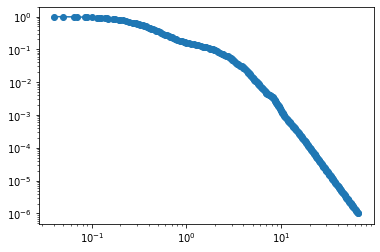

In [791]:
FF = FormFactorWriter(10, 1/y**2 * 1/(1-y))
FF.brute(Ns = 30)
FF.plot()

[(0, 10), (0, 10), (0, 10), (0, 15), (0, 10)]
[ 1.73809607e+00 -1.28404185e-03  7.55309400e-01  1.19266335e+01
  9.60610512e+00]
Relative Error 0.04291333351795886
R2: 0.005191254921825631


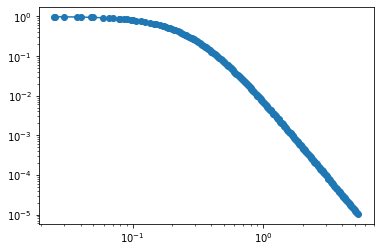

In [777]:
from scipy.optimize import brute
FF = FormFactorWriter(1, 1/y**2 * 1/(1-y))
FF.brute(Ns = 15)
FF.plot()

In [736]:
FF = FormFactorWriter(1, 1/y**2 * 1/(1-y))

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

Relative Error 20.03052154839579
R2: 0.0002962783938749416


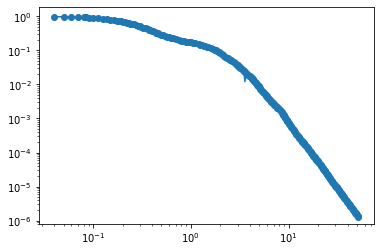

In [699]:
#FF = FormFactorWriter(1, 1/y) #1197.452053454899
FF = FormFactorWriter(8, y**4*(1-y)**2)
FF.plot()

In [604]:
FF.fit(0.0000001)

1.1149481014470846

In [362]:
coefs_symb = list(r)
coefs_symb = coefs_symb[:-1]

dic = {}
for n, symbol in enumerate(coefs_symb):
    dic[symbol] = coefs[n]

In [363]:
dic

{a_1: -3.356242477573499e-05,
 a_2: 8.489563280333101e-08,
 a_3: -5.2333208027608916e-11,
 b_1: -3.973270481407568e-47,
 b_2: -9.877744097579256e-42,
 b_3: -2.051588947809922e-36,
 b_4: -1.8747787150756235e-35}

In [364]:
f = N/D
fit = f.subs(dic)
fit

(-5.23332080276089e-11*x**4 + 8.4895632803331e-8*x**3 - 3.3562424775735e-5*x**2 + 1)/(-1.87477871507562e-35*x**8 - 2.05158894780992e-36*x**6 - 9.87774409757926e-42*x**4 - 3.97327048140757e-47*x**2 + 1)

In [365]:
fit = sy.lambdify(x, fit)

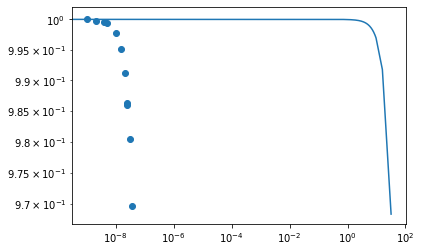

In [366]:
from matplotlib.pyplot import *
figure()
ax = gca()
ax.plot(xAxis[:-5], fit(xAxis)[:-5])
ax.scatter(xAxis[:-5], yAxis[:-5])


ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
class FormFactorWriter:
    def __init__(self, Z, w):
        

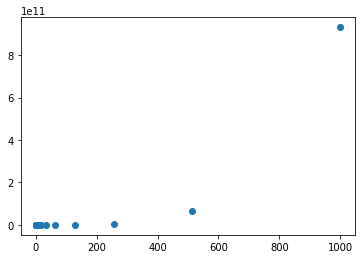

In [299]:
scatter(xAxis, (fit(xAxis) - yAxis)**2)

In [189]:
f = N/D


for key in dic:
    if dic[key] == 1: break
    f = f.subs(key, dic[key])


In [190]:
f

1.0*(-4.6390546721404e-9*x**4 + 1.71322310345586e-6*x**3 + 0.967879525076527*x**2 + 1.42098570253358e-31)*(-4.73906950815593e-21*x**8 - 1.49203263094209e-22*x**6 - 2.73025702486079e-11*x**4 + x**2 + 4.80378427855619e-20)**(-1.42098570253358e-31)

In [ ]:
x, y = sy.symbols('x y')

D*y - N

Ok, now that I have this set up, I'm going to try to formulate the objective function:

$$\sum_k (N(x_k) - y_k D(x_k))^2$$

In [7]:
y = sy.Symbol('y')

eps = (N-y*D)**2

eps.expand()

a_1**2*x**4 + 2*a_1*a_2*x**5 + 2*a_1*a_3*x**6 - 2*a_1*b_1*x**4*y - 2*a_1*b_2*x**6*y - 2*a_1*b_3*x**8*y - 2*a_1*b_4*x**10*y - 2*a_1*x**2*y + 2*a_1*x**2 + a_2**2*x**6 + 2*a_2*a_3*x**7 - 2*a_2*b_1*x**5*y - 2*a_2*b_2*x**7*y - 2*a_2*b_3*x**9*y - 2*a_2*b_4*x**11*y - 2*a_2*x**3*y + 2*a_2*x**3 + a_3**2*x**8 - 2*a_3*b_1*x**6*y - 2*a_3*b_2*x**8*y - 2*a_3*b_3*x**10*y - 2*a_3*b_4*x**12*y - 2*a_3*x**4*y + 2*a_3*x**4 + b_1**2*x**4*y**2 + 2*b_1*b_2*x**6*y**2 + 2*b_1*b_3*x**8*y**2 + 2*b_1*b_4*x**10*y**2 + 2*b_1*x**2*y**2 - 2*b_1*x**2*y + b_2**2*x**8*y**2 + 2*b_2*b_3*x**10*y**2 + 2*b_2*b_4*x**12*y**2 + 2*b_2*x**4*y**2 - 2*b_2*x**4*y + b_3**2*x**12*y**2 + 2*b_3*b_4*x**14*y**2 + 2*b_3*x**6*y**2 - 2*b_3*x**6*y + b_4**2*x**16*y**2 + 2*b_4*x**8*y**2 - 2*b_4*x**8*y + y**2 - 2*y + 1

In [87]:
from numpy.polynomial import *

xAxis, yAxis = getData(1)


n, d = 4, 8


A = []
b = []
M = []

N = [0, 2, 3, 4]
D = [2, 4, 6, 8]

N = []

for x, y in zip(xAxis, yAxis):
    num = [x**i for i in N]
    den = [-y*x**i for i in D]
    line = array(num + den)
    M += [line]
    b += [x*y]

A = array(M)
b = array(b)

In [88]:
coefs, res, c, d = lstsq(A, b)

C:\Users\araujoj\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [89]:
coefs

array([ 4.39671835e-09, -2.34509591e-13,  6.35003587e-16, -4.04904776e-19,
        1.10549411e-29,  6.04131138e-41,  1.91887188e-39, -1.94507520e-38])

In [80]:
p = Polynomial((1, 0, coefs[0]))

q = Polynomial([1] + list(coefs[4:]))

In [84]:
f = lambda x: p(x)/q(x)
yAxis -  f(xAxis)

array([ 9.99999996e-01,  9.99999996e-01,  9.99763087e-01, ...,
       -4.37150631e-09, -4.38876642e-09, -4.39230757e-09])

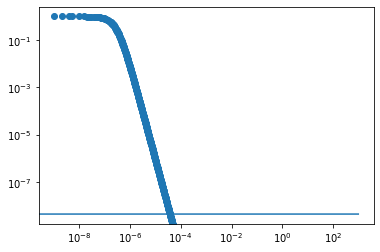

In [86]:
from matplotlib.pyplot import *
figure()
ax = gca()
ax.plot(xAxis, f(xAxis))
ax.scatter(xAxis, yAxis)


ax.set_yscale('log')
ax.set_xscale('log')


In [23]:
from numpy.linalg import lstsq
lstsq(M)

In [24]:
help(lstsq)

Help on function lstsq in module numpy.linalg:

lstsq(a, b, rcond='warn')
    Return the least-squares solution to a linear matrix equation.
    
    Solves the equation :math:`a x = b` by computing a vector `x` that
    minimizes the squared Euclidean 2-norm :math:`\| b - a x \|^2_2`.
    The equation may be under-, well-, or over-determined (i.e., the
    number of linearly independent rows of `a` can be less than, equal
    to, or greater than its number of linearly independent columns).
    If `a` is square and of full rank, then `x` (but for round-off error)
    is the "exact" solution of the equation.
    
    Parameters
    ----------
    a : (M, N) array_like
        "Coefficient" matrix.
    b : {(M,), (M, K)} array_like
        Ordinate or "dependent variable" values. If `b` is two-dimensional,
        the least-squares solution is calculated for each of the `K` columns
        of `b`.
    rcond : float, optional
        Cut-off ratio for small singular values of `a`.
       

# TO DISCARD:

In [ ]:
    def makeLowLevelError(self):
        w, xAxis, yAxis = self.w, self.xAxis, self.yAxis
        @njit
        def error(param):
            a1, a2, a3, a4, a5 = param
            x = xAxis
            A = 1 + a1*x**2 + a2 * x**3 + a3 * x**4
            B = 1 + a4*x**2 + a5 * x**4
            yAxisTrue = A/B**2
            return sum(w*(yAxisTrue - yAxis)**2)
        
        return error

In [163]:
H.error([1, 2, 3, 4, 5])

C:\Users\araujoj\anaconda3\lib\site-packages\numba\ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'param' of function 'FormFactorWriter.makeLowLevelError.<locals>.error'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-159-b0728893ce85>", line 45:
        @njit
        def error(param):
        ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


ValueError: unable to broadcast argument 1 to output array
File "<ipython-input-159-b0728893ce85>", line 51, 

In [ ]:
Z = 2

xAxis, yAxis = getData(Z)
xAxis, yAxis = xAxis*10**6, yAxis 

param = (0, 0, 0, 1.1055E1, 0)
param = [ 1.47053652e+01, -5.25878312e-02,  5.35868889e+01,  1.84093467e+01,
          8.09233981e+01]

param = [ 2.02312995e+01, -9.79242032e-02,  9.82125918e+01,  2.11711489e+01, 1.09554041e+02]
param = [100.        , -60.49589745,  50.        ,  15.58352067,
        14.91808461]

Regardless, I'm advancing with the optimization algorithm.

In [43]:
yAxis, xAxis = yAxis[3:], xAxis[3:]

In [44]:
from scipy.optimize import minimize, curve_fit, least_squares, brute
#help(least_squares)

w = yAxis**2 * (Z - yAxis)
w = 1/w

@njit
def error(param):
    a1, a2, a3, a4, a5 = param
    #yAxisTrue = func(xAxis, *param)
    x = xAxis
    A = 1 + a1*x**2 + a2 * x**3 + a3 * x**4
    B = 1 + a4*x**2 + a5 * x**4
    yAxisTrue = A/B**2
    return sum(w*(yAxisTrue - yAxis)**2)

In [116]:
#help(brute)
#brute(error, (0, 0, 0, 1.1055E1, 0)).e
from scipy.optimize import basinhopping, brute, dual_annealing, shgo, differential_evolution

#basinhopping(error, (0, 0, 0, 1.1055E1, 0))

w = yAxis**2 * (Z - yAxis)
w = 1/w

ranges = ((0, 85), (-110, 190), (0, 1100),  (0, 50),  (0, 60))
#ranges = 5*[(0,7)]

#param = brute(error, ranges, Ns=11)
#error(param)
#array([ 2.02312995e+01, -9.79242032e-02,  9.82125918e+01,  2.11711489e+01, 1.09554041e+02])


#res = shgo(error, ranges, options = dict(fmin = 1e-16, f_tol = 1e-3))
rest = differential_evolution(error, ranges)
error(res.x)



2587.0178331466564

In [106]:
res

     fun: 2587.0178331466564
    funl: array([2587.01783315])
 message: 'Optimization terminated successfully.'
    nfev: 199
     nit: 2
   nlfev: 166
   nlhev: 0
   nljev: 20
 success: True
       x: array([1.00000000e+01, 1.44093498e-15, 1.00000000e+01, 5.22527921e+00,
       6.99419934e+00])
      xl: array([[1.00000000e+01, 1.44093498e-15, 1.00000000e+01, 5.22527921e+00,
        6.99419934e+00]])

In [292]:
from scipy.optimize import minimize, curve_fit, least_squares
from bayes_opt import BayesianOptimization

xAxis, yAxis = xAxis[3:], yAxis[3:]
w = yAxis**2 * (Z - yAxis)
w = 1/w

@njit
def func(x, a1, a2, a3, a4, a5):
    """x = 10**-10 * sin(theta/2)/lambda"""
    A = 1 + a1*x**2 + a2 * x**3 + a3 * x**4
    B = 1 + a4*x**2 + a5 * x**4
    return A/B**2

def error(a1, a2, a3, a4, a5):
    yAxisTrue = func(xAxis, a1, a2, a3, a4, a5)
    #yAxisTrue = log10(yAxisTrue)
    #yAxis0 = log10(yAxis)
    return sum(w*(yAxisTrue - yAxis)**2)

print(error(*(0, 0, 0, 1.1055E1, 0)))
pbounds = {'a1': (0, 12), 'a2': (0, 12), 'a3': (0, 12), 'a4': (0, 12), 'a5': (0, 12)}
#pbounds = {'x': (2, 4), 'y': (-3, 3)}

optimizer = BayesianOptimization(
    f=error,
    pbounds=pbounds,
    random_state=1,
)

#print(error((0, 0, 0, 1.1055E1, 0)))
#error(guess)

#minimize(error, (0, 0, 0, 1.1055E1, 0), method='Nelder-Mead')

4.3350654094092566e-05


In [289]:
optimizer.maximize(init_points=2)

|   iter    |  target   |    a1     |    a2     |    a3     |    a4     |    a5     |
-------------------------------------------------------------------------------------
|  31       |  0.000109 |  10.74    |  1.021    |  0.4687   |  2.038    |  10.54    |
|  32       |  2.352e-0 |  1.18     |  5.053    |  11.49    |  6.398    |  8.303    |
|  33       |  5.729e-1 |  11.99    |  11.76    |  0.9987   |  3.548    |  0.0169   |
|  34       |  8.572e-2 |  0.0      |  0.0      |  3.722e-0 |  8.344e-0 |  1.918e-0 |
|  35       |  7.133e-1 |  2.891    |  11.56    |  10.84    |  0.2305   |  0.6212   |
|  36       |  8.772e-0 |  8.62     |  11.91    |  11.93    |  11.9     |  11.64    |
|  37       |  1.076e-0 |  4.241    |  0.1629   |  7.808    |  11.94    |  9.64     |
|  38       |  3.846e-1 |  11.05    |  0.2427   |  10.86    |  1.373    |  0.05054  |
|  39       |  6.029e-0 |  11.8     |  11.36    |  11.6     |  0.2076   |  12.0     |
|  40       |  1.061e-1 |  0.1752   |  11.41    |  11.

In [267]:
x = array([ 2.09073276e-05, -8.49064687e-07,  3.12488370e-09,  1.21212653e+01, -3.54921017e-04])

In [250]:
error(res.x)

0.0771036947675938

In [225]:
fun = lambda x: (x[0] - 1)**2 + (x[1] - 2.5)**2
es = minimize(fun, (2, 0))

In [211]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

In [167]:
class FitFormFactor:
    def __init__(xAxis, yAxis, Z):
        self.Z = Z
        self.xAxis, self.yAxis = xAxis, yAxis
        
        self.w = yAxis**2 * (Z - yAxis)
        self.w = 1/self.w
    
    def get_error(self):
        return sum(self.w*(func(self.xAxis) - self.yAxis)**2)
    
    
@njit
def func(x, a1, a2, a3, a4, a5):
    """x = 10**-10 * sin(theta/2)/lambda"""
    A = 1 + a1*x**2 + a2 * x**3 + a3 * x**4
    B = 1 + a4*x**2 + a5 * x**4
    return A/B**2

def get_error()

def get_param(func, xAxis, yAxis):
    pass

Help on function curve_fit in module scipy.optimize.minpack:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)
    Use non-linear least squares to fit a function, f, to data.
    
    Assumes ``ydata = f(xdata, *params) + eps``
    
    Parameters
    ----------
    f : callable
        The model function, f(x, ...).  It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : array_like or object
        The independent variable where the data is measured.
        Should usually be an M-length sequence or an (k,M)-shaped array for
        functions with k predictors, but can actually be any object.
    ydata : array_like
        The dependent data, a length M array - nominally ``f(xdata, ...)``.
    p0 : array_like, optional
        Initial guess for the parameters (length N).  If None, then the
        init

In [77]:
param = (1, 1, 1, 1, 1)
func(2, *param)

0.06575963718820861

In [161]:
xAxis #[Angstrom -1]

array([2.00e-09, 4.00e-09, 5.00e-09, ..., 2.56e+02, 5.12e+02, 1.00e+03])

In [164]:
xAxis*10**6

array([0.00e+00, 1.00e-03, 2.00e-03, ..., 2.56e+08, 5.12e+08, 1.00e+09])

In [158]:
param = (0, 0, 0, 1.1055E1, 0)
diff  = (func(xAxis*10**6, *param) - yAxis)**2
weight = ((yAxis**2)*(Z - yAxis))**-1

In [159]:
sum(diff*weight)

0.00016743963320773486

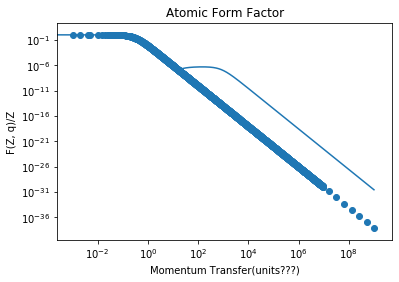

In [124]:
func(xAxis, *param)[0]

1.0

In [125]:
yAxis[0]

0.999763091

In [525]:
import sympy as sy
x, y, a1, a2, a3, a4, a5 = sy.symbols('x y a_1 a_2 a_3 a_4 a_5')

N = 1 + a1*x**2 + a2*x**3 + a3*x**4
D = 1 + a4*x**2 + a5* x**4

model = N/D**2

In [541]:
model

(a_1*x**2 + a_2*x**3 + a_3*x**4 + 1)/(a_4*x**2 + a_5*x**4 + 1)**2

In [540]:
model.expand()

a_1*x**2/(a_4**2*x**4 + 2*a_4*a_5*x**6 + 2*a_4*x**2 + a_5**2*x**8 + 2*a_5*x**4 + 1) + a_2*x**3/(a_4**2*x**4 + 2*a_4*a_5*x**6 + 2*a_4*x**2 + a_5**2*x**8 + 2*a_5*x**4 + 1) + a_3*x**4/(a_4**2*x**4 + 2*a_4*a_5*x**6 + 2*a_4*x**2 + a_5**2*x**8 + 2*a_5*x**4 + 1) + 1/(a_4**2*x**4 + 2*a_4*a_5*x**6 + 2*a_4*x**2 + a_5**2*x**8 + 2*a_5*x**4 + 1)

In [566]:
@njit
def func(x, a1, a2, a3, a4, a5):
    """x = 10**-10 * sin(theta/2)/lambda"""
    A = 1 + a1*x**2 + a2 * x**3 + a3 * x**4
    B = 1 + a4*x**2 + a5 * x**4
    return A/B**2

from scipy.optimize import curve_fit
Z = 3
xAxis, yAxis = getData(Z)
param, _ = curve_fit(func, xAxis, yAxis/Z)

f = lambda x: func(x, *param)

In [564]:
sum(abs(f(xAxis)-yAxis)/yAxis)

2.2582809612502884e+19

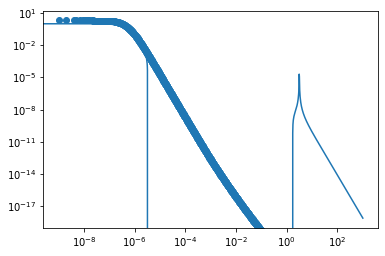

In [565]:
figure()
ax = gca()
ax.plot(xAxis, f(xAxis))
ax.scatter(xAxis, yAxis)
ax.set_yscale('log')
ax.set_xscale('log')

In [43]:
from sympy import *

r, x, a, b, u, v, Pv, Pu = symbols('r x a b u v Pv Pu')

nu = (r - Pu)/(Pv - Pu)
A = (1 + a + b)*nu
B = 1 + a*nu + b*nu**2
u + A*(v-u)/B

u + (-Pu + r)*(-u + v)*(a + b + 1)/((-Pu + Pv)*(a*(-Pu + r)/(-Pu + Pv) + b*(-Pu + r)**2/(-Pu + Pv)**2 + 1))

In [44]:
solve(Eq(x, u + A*(v-u)/B), r)

[(Pu*a*v - Pu*a*x + Pu*b*u + Pu*b*v - 2*Pu*b*x - Pu*u + Pu*v - Pv*a*v + Pv*a*x + Pv*b*u - Pv*b*v + Pv*u - Pv*v + (-Pu + Pv)*sqrt(a**2*v**2 - 2*a**2*v*x + a**2*x**2 - 2*a*b*u*v + 2*a*b*u*x + 2*a*b*v**2 - 2*a*b*v*x - 2*a*u*v + 2*a*u*x + 2*a*v**2 - 2*a*v*x + b**2*u**2 - 2*b**2*u*v + b**2*v**2 - 2*b*u**2 - 4*b*u*v + 8*b*u*x + 2*b*v**2 - 4*b*x**2 + u**2 - 2*u*v + v**2))/(2*b*(u - x)),
 (Pu*a*v - Pu*a*x + Pu*b*u + Pu*b*v - 2*Pu*b*x - Pu*u + Pu*v - Pv*a*v + Pv*a*x + Pv*b*u - Pv*b*v + Pv*u - Pv*v + (Pu - Pv)*sqrt(a**2*v**2 - 2*a**2*v*x + a**2*x**2 - 2*a*b*u*v + 2*a*b*u*x + 2*a*b*v**2 - 2*a*b*v*x - 2*a*u*v + 2*a*u*x + 2*a*v**2 - 2*a*v*x + b**2*u**2 - 2*b**2*u*v + b**2*v**2 - 2*b*u**2 - 4*b*u*v + 8*b*u*x + 2*b*v**2 - 4*b*x**2 + u**2 - 2*u*v + v**2))/(2*b*(u - x))]

In [45]:
sol = _

In [48]:
sol

[(Pu*a*v - Pu*a*x + Pu*b*u + Pu*b*v - 2*Pu*b*x - Pu*u + Pu*v - Pv*a*v + Pv*a*x + Pv*b*u - Pv*b*v + Pv*u - Pv*v + (-Pu + Pv)*sqrt(a**2*v**2 - 2*a**2*v*x + a**2*x**2 - 2*a*b*u*v + 2*a*b*u*x + 2*a*b*v**2 - 2*a*b*v*x - 2*a*u*v + 2*a*u*x + 2*a*v**2 - 2*a*v*x + b**2*u**2 - 2*b**2*u*v + b**2*v**2 - 2*b*u**2 - 4*b*u*v + 8*b*u*x + 2*b*v**2 - 4*b*x**2 + u**2 - 2*u*v + v**2))/(2*b*(u - x)),
 (Pu*a*v - Pu*a*x + Pu*b*u + Pu*b*v - 2*Pu*b*x - Pu*u + Pu*v - Pv*a*v + Pv*a*x + Pv*b*u - Pv*b*v + Pv*u - Pv*v + (Pu - Pv)*sqrt(a**2*v**2 - 2*a**2*v*x + a**2*x**2 - 2*a*b*u*v + 2*a*b*u*x + 2*a*b*v**2 - 2*a*b*v*x - 2*a*u*v + 2*a*u*x + 2*a*v**2 - 2*a*v*x + b**2*u**2 - 2*b**2*u*v + b**2*v**2 - 2*b*u**2 - 4*b*u*v + 8*b*u*x + 2*b*v**2 - 4*b*x**2 + u**2 - 2*u*v + v**2))/(2*b*(u - x))]

In [49]:
sol[0]

(Pu*a*v - Pu*a*x + Pu*b*u + Pu*b*v - 2*Pu*b*x - Pu*u + Pu*v - Pv*a*v + Pv*a*x + Pv*b*u - Pv*b*v + Pv*u - Pv*v + (-Pu + Pv)*sqrt(a**2*v**2 - 2*a**2*v*x + a**2*x**2 - 2*a*b*u*v + 2*a*b*u*x + 2*a*b*v**2 - 2*a*b*v*x - 2*a*u*v + 2*a*u*x + 2*a*v**2 - 2*a*v*x + b**2*u**2 - 2*b**2*u*v + b**2*v**2 - 2*b*u**2 - 4*b*u*v + 8*b*u*x + 2*b*v**2 - 4*b*x**2 + u**2 - 2*u*v + v**2))/(2*b*(u - x))

In [50]:
sol[1]

(Pu*a*v - Pu*a*x + Pu*b*u + Pu*b*v - 2*Pu*b*x - Pu*u + Pu*v - Pv*a*v + Pv*a*x + Pv*b*u - Pv*b*v + Pv*u - Pv*v + (Pu - Pv)*sqrt(a**2*v**2 - 2*a**2*v*x + a**2*x**2 - 2*a*b*u*v + 2*a*b*u*x + 2*a*b*v**2 - 2*a*b*v*x - 2*a*u*v + 2*a*u*x + 2*a*v**2 - 2*a*v*x + b**2*u**2 - 2*b**2*u*v + b**2*v**2 - 2*b*u**2 - 4*b*u*v + 8*b*u*x + 2*b*v**2 - 4*b*x**2 + u**2 - 2*u*v + v**2))/(2*b*(u - x))